# Introduction
Classify whether a specific loan is approved or not, based on the features of the applicant, and that of the loan.

# Approach
Begin by exploring the data (and finding relationship between features), before we start data cleaning. In this case, data cleaning takes 2 forms:

1. Imputing missing data using the relationship across different features (where applicable); and
2. Removing anomalies from the data using arbitrary thresholds.

Following which, we proceed to generate new features, and remove features which are either uninformative of the target label, or cannot be used for the purpose of predicting for the test dataset, either because the competition prohibits the use of such features, or because there were too many missing values.  

For the purpose of prediction, we employ an Extreme Gradient Boosting model with hyperparameter tuning (informal; not done through GridSearchCV) to find the optimal model that will maximise the roc_auc score - the metric used for evaluating our predictions.

Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
import xgboost as xgb

Load training testing dataset and combine into one

In [2]:
def read_dataframe():
    train = pd.read_csv('data/train.csv')
    test = pd.read_csv('data/test.csv')

    nrow_train = train.shape[0]
    combined = pd.concat([train, test])

    combined.reset_index(drop=True, inplace=True)

    return train, test, combined, nrow_train

train, test, combined, nrow_train = read_dataframe()

Exploratory Data Analysis

In [3]:
combined.head()

,ID,Gender,DOB,Lead_Creation_Date,City_Code,City_Category,Employer_Code,Employer_Category1,Employer_Category2,Monthly_Income,...,Contacted,Source,Source_Category,Existing_EMI,Loan_Amount,Loan_Period,Interest_Rate,EMI,Var1,Approved
0,APPC90493171225,Female,23/07/79,15/07/16,C10001,A,COM0044082,A,4.0,2000.0,...,N,S122,G,0.0,NaN,NaN,NaN,NaN,0,0.0
1,APPD40611263344,Male,07/12/86,04/07/16,C10003,A,COM0000002,C,1.0,3500.0,...,Y,S122,G,0.0,20000.0,2.0,13.25,953.0,10,0.0
2,APPE70289249423,Male,10/12/82,19/07/16,C10125,C,COM0005267,C,4.0,2250.0,...,Y,S143,B,0.0,45000.0,4.0,NaN,NaN,0,0.0
3,APPF80273865537,Male,30/01/89,09/07/16,C10477,C,COM0004143,A,4.0,3500.0,...,Y,S143,B,0.0,92000.0,5.0,NaN,NaN,7,0.0
4,APPG60994436641,Male,19/04/85,20/07/16,C10002,A,COM0001781,A,4.0,10000.0,...,Y,S134,B,2500.0,50000.0,2.0,NaN,NaN,10,0.0


There are a total of 22 columns, and there are NA values in the dataset. Also, there are categorical and numerical features in the dataset. To get a better of the data, we can call the describe function.

In [4]:
combined.describe(include='all')

,ID,Gender,DOB,Lead_Creation_Date,City_Code,City_Category,Employer_Code,Employer_Category1,Employer_Category2,Monthly_Income,...,Contacted,Source,Source_Category,Existing_EMI,Loan_Amount,Loan_Period,Interest_Rate,EMI,Var1,Approved
count,99750,99750,99732,99750,98622,98622,94127,94127,93757.000000,9.975000e+04,...,99750,99750,99750,99667.000000,60170.000000,60170.000000,31928.000000,31928.000000,99750.000000,69713.000000
unique,99750,2,11672,92,704,3,48281,3,NaN,NaN,...,2,33,7,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,APPC90493171225,Male,11/01/82,02/09/16,C10001,A,COM0000002,A,NaN,NaN,...,Y,S122,B,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,1,57153,345,2614,14313,71383,622,47805,NaN,NaN,...,64772,44213,42743,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.722623,5.126893e+03,...,NaN,NaN,NaN,357.310193,39445.986372,3.894399,19.233814,1099.485718,3.952622,0.014631
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.803623,1.466628e+05,...,NaN,NaN,NaN,1990.517471,30667.188339,1.162487,5.857761,745.125218,3.819744,0.120073
min,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,0.000000e+00,...,NaN,NaN,NaN,0.000000,5000.000000,1.000000,11.990000,118.000000,0.000000,0.000000
25%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.000000,1.650000e+03,...,NaN,NaN,NaN,0.000000,20000.000000,3.000000,15.250000,642.750000,0.000000,0.000000
50%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.000000,2.500000e+03,...,NaN,NaN,NaN,0.000000,30000.000000,4.000000,18.000000,943.000000,2.000000,0.000000
75%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.000000,4.000000e+03,...,NaN,NaN,NaN,350.000000,50000.000000,5.000000,20.000000,1293.000000,7.000000,0.000000


To find the correlation between different columns using .corr() function. We will use seaborn heatmap to visulize the correlation across the different features.

There might be anomalies in the dataset. For example, we note that for EMI, Loan Amount and Monthly Income has a very skewed distribution, judging by their mean-to-standard deviation ratio. 

Come to this later, when we search for anomalies in the dataset.

<Axes: >

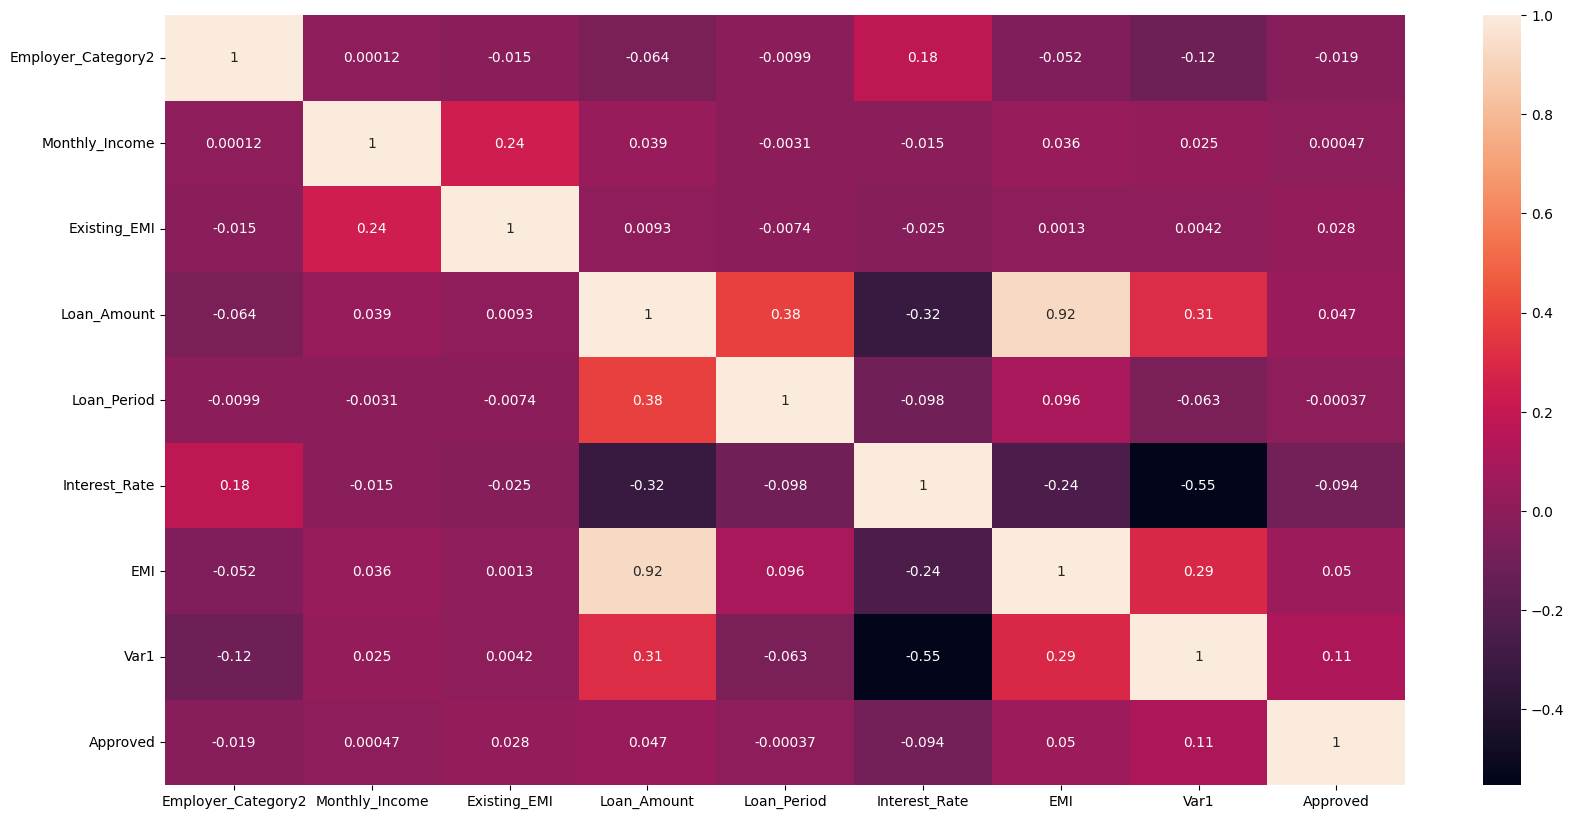

In [5]:
numeric_columns = combined.select_dtypes(include=[np.number])
plt.figure(figsize=(20, 10))
sns.heatmap(numeric_columns.corr(), annot=True)

#plt.figure(figsize=(20,10))
#sns.heatmap(combined.corr(), annot=True)

From the heatmap, features: EMI and Loan Amount are highly correlated with one another (correlation was 0.92). This might lead to multicollinearity. Also, based on the correlation with the target label ('Approved'), we find that the informative features are EMI, Interest, Loan Amount and Var1.

However, we should note that the correlation we are dealing with do not control for the other factors in the dataset.

Let's find out which columns have missing values.

In [6]:
np.sum(combined.isnull())/combined.shape[0]

ID                                     0.000000
Gender                                 0.000000
DOB                                    0.000180
Lead_Creation_Date                     0.000000
City_Code                              0.011308
City_Category                          0.011308
Employer_Code                          0.056371
Employer_Category1                     0.056371
Employer_Category2                     0.060080
Monthly_Income                         0.000000
Customer_Existing_Primary_Bank_Code    0.134617
Primary_Bank_Type                      0.134617
Contacted                              0.000000
Source                                 0.000000
Source_Category                        0.000000
Existing_EMI                           0.000832
Loan_Amount                            0.396792
Loan_Period                            0.396792
Interest_Rate                          0.679920
EMI                                    0.679920
Var1                                   0

Observe that the feature pairs, City_Category and City_Code, Employer_Category1 and Employer_Code, Loan_Amount and Loan_Period, Interest Rate and EMI, and Customer_Existing_Primary_Bank_Code and Primary_Bank_Type have the same amount of missing values. It appears so that features are independent. For example, it is not possible to have a city category without a city code. Also, without an Employer Code, it is not possible to have an employer category.

In [7]:
import numpy as np

# Relationship between City Category and City Code
print(np.sum(combined['City_Category'].isnull()) == combined[combined['City_Category'].isnull() & combined['City_Code'].isnull()].shape[0])

# Relationship between Employer Category1 and Employer Code
print(np.sum(combined['Employer_Code'].isnull()) == combined[combined['Employer_Category1'].isnull() & combined['Employer_Code'].isnull()].shape[0])

# Relationship between Loan Amount and Loan_Period
print(np.sum(combined['Loan_Amount'].isnull()) == combined[combined['Loan_Amount'].isnull() & combined['Loan_Period'].isnull()].shape[0])

# Relationship between Interest Rate and EMI
print(np.sum(combined['EMI'].isnull()) == combined[combined['EMI'].isnull() & combined['Interest_Rate'].isnull()].shape[0])

# Relationship between Customer Existing Primary Bank Code and Primary Bank Type
print(np.sum(combined['Primary_Bank_Type'].isnull()) == combined[combined['Customer_Existing_Primary_Bank_Code'].isnull() & combined['Primary_Bank_Type'].isnull()].shape[0])


True
True
True
True
True


Remove feaatures that contains more than 20% missing data. In its place, we will create binary features to indicate whether the applicant had missing data.

Using the threshold of 20%, we note that the following features will be removed: 'EMI', 'Interest_Rate', 'Loan_Amount', 'Loan_Period'; previously, we note that the missing values across the 4 different columns are common with one another - we will only create 2 columns in this case.

In [8]:
def add_binary_features(combined):

    combined['Missing_Loan_EMI'] = combined.EMI.isnull()
    combined['Missing_Loan_Amount'] = combined.Loan_Amount.isnull()

    return combined

combined = add_binary_features(combined)

In [9]:
del combined['EMI']
del combined['Interest_Rate']
del combined['Loan_Amount']
del combined['Loan_Period']

Missing Data Imputation

Before we impute missing data, develop a missing data strategy. The data description file provides us with some information pertaining to how we should be imputing missing data - for example, we note that EMI refers to Existing Monthly Installment, while Existing EMI refers to the applicant's EMI of existing loans.

In this case, we can impute missing data for numerical features using the mean of the features, create new categories for missing data for categorical features, and use the most common date to impute for missing data found in date features. Where possible, we will make use of the domain knowledge that we have acquired to impute missing data.

In [10]:
def impute_missing_data(combined):
    # Obtain categorical, numerical and date feature names
    categorical_features = ['City_Category', 'City_Code', 'Contacted', 'Customer_Existing_Primary_Bank_Code',
                            'Employer_Category1', 'Employer_Category2', 'Employer_Code', 'Gender', 'ID',
                            'Primary_Bank_Type', 'Source', 'Source_Category', 'Var1']

    date_features = ['DOB', 'Lead_Creation_Date']

    numerical_features = [feat for feat in combined.columns.tolist()
                          if feat not in categorical_features and feat not in date_features
                          and not feat.startswith('Missing') and feat != 'Approved']

    # Imputing most common values for date and categorical features
    for feat in categorical_features:
        combined[feat].fillna('-1', inplace=True)

    for feat in date_features:
        mode = combined[feat].value_counts().index[0]
        combined[feat].fillna(mode, inplace=True)

    # Imputing median for numerical features
    for feat in numerical_features:
        mean = combined.describe().loc['mean', feat]
        combined[feat].fillna(mean, inplace=True)

    return combined

combined = impute_missing_data(combined)

Encode the categorical features using sklearn LabelEncoder.

In [11]:
# label_encoding(combined)
from sklearn.preprocessing import LabelEncoder

def label_encoding(combined):
    categorical_features = ['City_Category', 'City_Code', 'Contacted', 'Customer_Existing_Primary_Bank_Code',
                            'Employer_Category1', 'Employer_Category2', 'Employer_Code', 'Gender', 'ID',
                            'Primary_Bank_Type', 'Source', 'Source_Category', 'Var1', 'Missing_Loan_EMI',
                            'Missing_Loan_Amount']

    for feat in categorical_features:
        enc = LabelEncoder()

        # Convert all values to strings before applying LabelEncoder
        combined[feat] = enc.fit_transform(combined[feat].astype(str))

    return combined

combined = label_encoding(combined)


In [12]:
print(combined)

          ID  Gender       DOB Lead_Creation_Date  City_Code  City_Category  \
0      11238       0  23/07/79           15/07/16          1              1   
1      13008       1  07/12/86           04/07/16          3              1   
2      17965       1  10/12/82           19/07/16        125              3   
3      22239       1  30/01/89           09/07/16        477              3   
4      25505       1  19/04/85           20/07/16          2              1   
...      ...     ...       ...                ...        ...            ...   
99745  26864       1  19/11/80           30/09/16          4              1   
99746  41869       1  23/08/93           30/09/16         14              2   
99747  43148       0  01/07/90           30/09/16          2              1   
99748  48702       0  27/02/73           30/09/16        177              3   
99749  53413       1  11/04/85           30/09/16         13              2   

       Employer_Code  Employer_Category1  Employer_

Correlation across the different features after imputing missing data.

<Axes: >

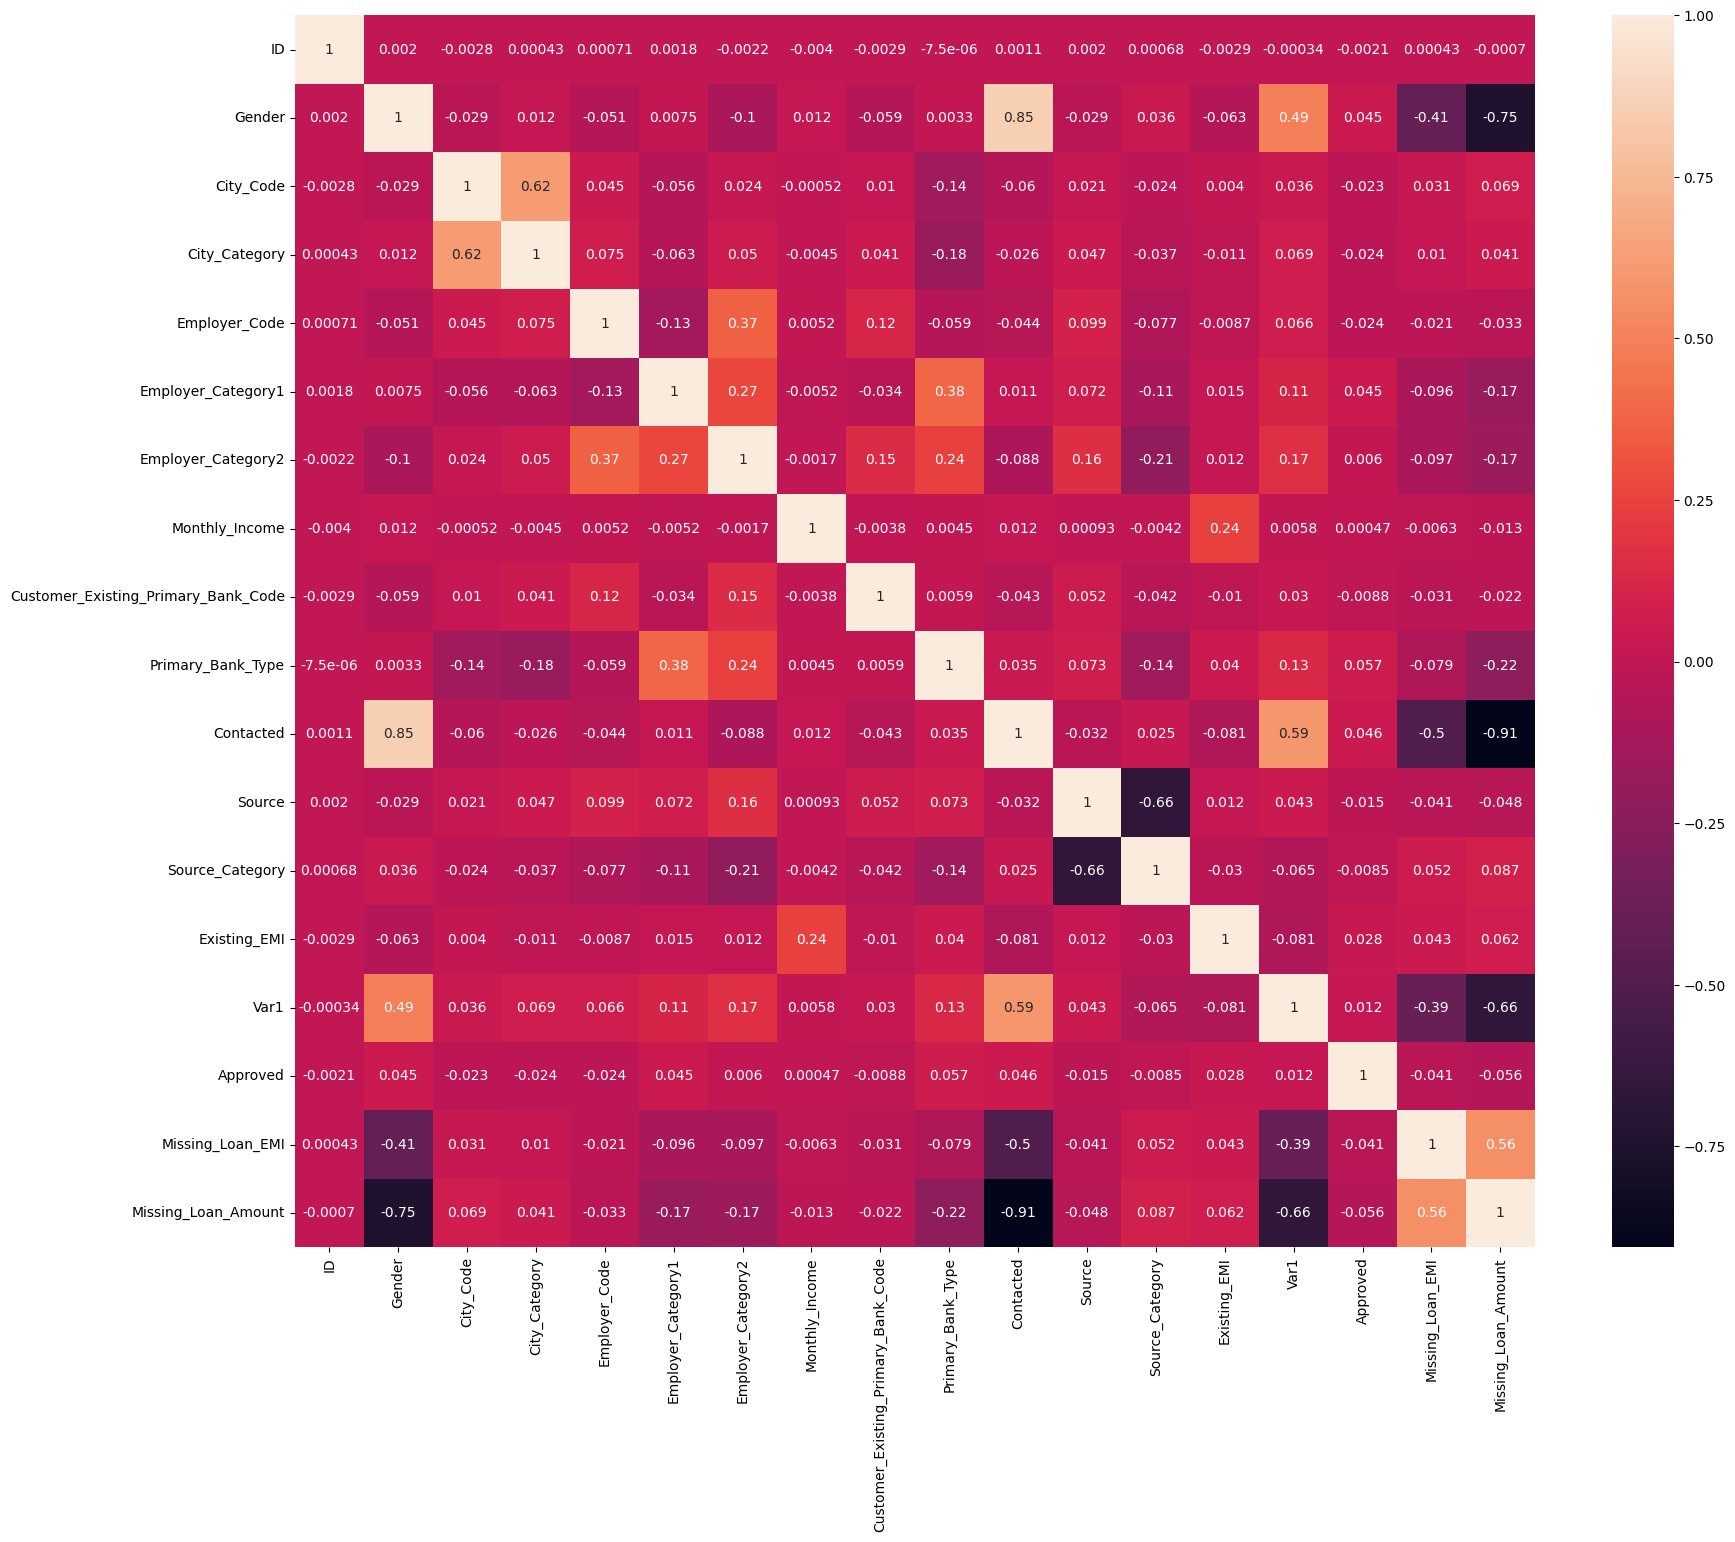

In [13]:
numeric_columns = combined.select_dtypes(include=[np.number])
plt.figure(figsize=(20, 16))
sns.heatmap(numeric_columns.corr(), annot=True)

Convert the date features to become age features. 

To do so, we convert the date features from str to datetime, and then we apply a linear transformation to obtain the age of the features.

In [14]:
def date_to_datetime(combined):
    combined['DOB'] = combined.DOB.apply(lambda date: date[:-2] + '19' + date[-2:])
    combined['DOB'] = pd.to_datetime(combined.DOB, format='%d/%m/%Y')

    combined['Lead_Creation_Date'] = pd.to_datetime(combined.Lead_Creation_Date, format='%d/%m/%y')

    return combined

combined = date_to_datetime(combined)

In [15]:
def get_age(combined):

    reference_date = pd.to_datetime(max(combined.Lead_Creation_Date))
    combined['Age'] = combined['Lead_Creation_Date'].subtract(combined['DOB']).apply(lambda timedelta: float(timedelta.days)/365)
    combined['Lead_Creation_Years'] = combined['Lead_Creation_Date'].apply(lambda date: float((reference_date - date).days)/365)

    del combined['DOB']
    del combined['Lead_Creation_Date']
    return combined

combined = get_age(combined)

Anomaly Search

Previously, we noted that there were anomalies in the dataset. Let's remove these anomalies

In [16]:
train.describe()

,Employer_Category2,Monthly_Income,Existing_EMI,Loan_Amount,Loan_Period,Interest_Rate,EMI,Var1,Approved
count,65415.000000,6.971300e+04,69662.000000,42004.000000,42004.000000,22276.000000,22276.000000,69713.000000,69713.000000
mean,3.720187,5.622283e+03,360.928751,39429.982859,3.890629,19.213570,1101.466242,3.948446,0.014631
std,0.807374,1.747671e+05,2288.517927,30727.595990,1.167491,5.847136,752.661394,3.819214,0.120073
min,1.000000,0.000000e+00,0.000000,5000.000000,1.000000,11.990000,118.000000,0.000000,0.000000
25%,4.000000,1.650000e+03,0.000000,20000.000000,3.000000,15.250000,649.000000,0.000000,0.000000
50%,4.000000,2.500000e+03,0.000000,30000.000000,4.000000,18.000000,941.000000,2.000000,0.000000
75%,4.000000,4.000000e+03,350.000000,50000.000000,5.000000,20.000000,1295.000000,7.000000,0.000000
max,4.000000,3.838384e+07,545436.500000,300000.000000,6.000000,37.000000,13556.000000,10.000000,1.000000


A quick look at the summary of the dataframe seems to suggest that there are anomalies for the following features: Existing_EMI and Monthly_Income. We will impose an arbitrary threshold of 150 times the 75th percentile of each feature, and remove observations that are higher than this threshold.

We will not remove observations in the test dataset that exceeds the threshold, as our task is to predict for these observations.

In [17]:
index_to_remove = combined[((combined.Monthly_Income > 600000) | (combined.Existing_EMI > 52500)) & (combined.Approved.notnull())].index.tolist()
index_to_keep = [index for index in combined.index.tolist() if index not in index_to_remove]

combined = combined.loc[index_to_keep, :]


Feature Generation and Selection

After imputing missing data, select features which are informative of the target label. Now, remove the ID feature from our dataset as it has been explicitly mentioned that the feature should not be used for the predictions.

In [18]:
del combined['ID']

Create a new feature: Take_Home_Pay using Monthly_Income and Existing_EMI that for the monthly installments paid on existing debt.

In [19]:
combined['Take_Home_Pay'] = combined['Monthly_Income'] - combined['Existing_EMI']

Now, conduct logarithmic transformation on the Monthly_Income and Existing_EMI features.

In [20]:
combined['Monthly_Income'] = np.log1p(combined['Monthly_Income'])
combined['Existing_EMI'] = np.log1p(combined['Existing_EMI'])

Now, the distribution of some of our numeric features to ensure that they are appropriate features to be included in our model.

C:\Users\patel\AppData\Local\Temp\ipykernel_2264\4147569609.py:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(combined[combined.Approved==1].Age, color='blue',
C:\Users\patel\AppData\Local\Temp\ipykernel_2264\4147569609.py:6: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(combined[combined.Appr

<Axes: xlabel='Take_Home_Pay', ylabel='Density'>

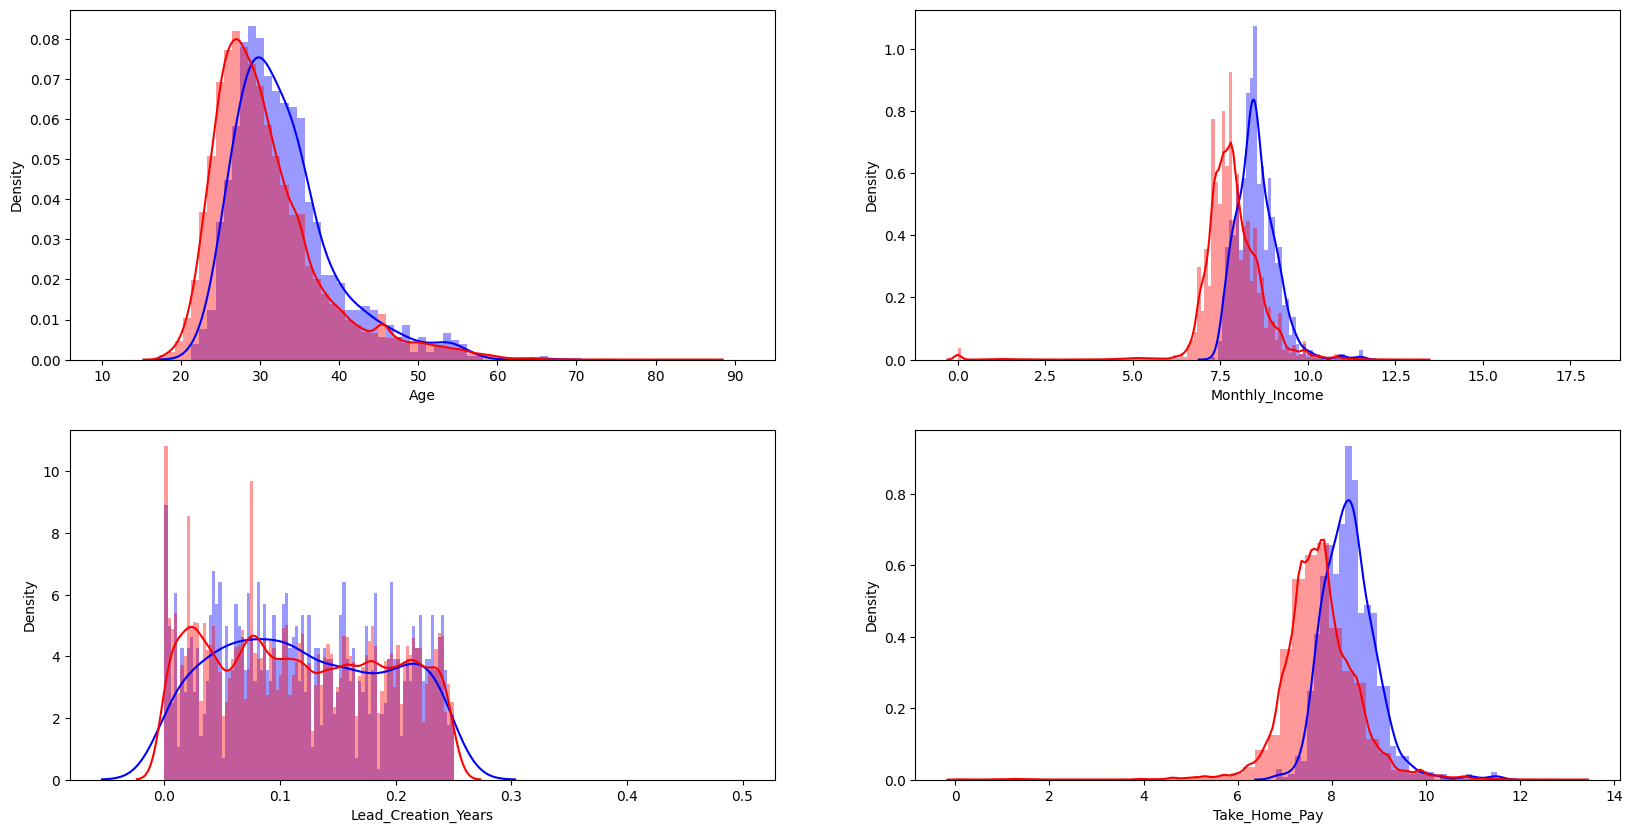

In [21]:
plt.figure(figsize=(20, 10))

plt.subplot(221)
sns.distplot(combined[combined.Approved==1].Age, color='blue',
             bins=np.linspace(10, 91, 80))
sns.distplot(combined[combined.Approved==0].Age, color='red',
             bins=np.linspace(10, 91, 80))

plt.subplot(222)
sns.distplot(combined[combined.Approved==1].Monthly_Income, color='blue',
             bins=np.linspace(0, 18, 180))
sns.distplot(combined[combined.Approved==0].Monthly_Income, color='red',
             bins=np.linspace(0, 18, 180))

plt.subplot(223)
sns.distplot(combined[combined.Approved==1].Lead_Creation_Years, color='blue',
             bins=np.linspace(0, 0.5, 183))
sns.distplot(combined[combined.Approved==0].Lead_Creation_Years, color='red',
             bins=np.linspace(0, 0.5, 183))

plt.subplot(224)
sns.distplot(np.log1p(combined[(combined.Approved==1) & (combined.Take_Home_Pay>0)].Take_Home_Pay), color='blue')
sns.distplot(np.log1p(combined[(combined.Approved==0) & (combined.Take_Home_Pay>0)].Take_Home_Pay), color='red')

Nothing seems outstanding from the graph

Model Training, Fitting and Prediction

Split combined dataset into the training and test data. The training dataset will be used to train the model, which will be used to predict for the target label in the test data using the features located in the test data.

We will be training an Extreme Gradient Boosting Model using the XGBoost library in Python.

In [22]:
def train_test_split(combined):
    target_label = 'Approved'
    features = [feat for feat in combined.columns.tolist() if feat != target_label]

    train_idx = combined[combined.Approved.notnull()].index.tolist()
    test_idx = combined[combined.Approved.isnull()].index.tolist()

    X_train = combined.loc[train_idx, features].values
    X_test = combined.loc[test_idx, features].values
    y_train = combined.loc[train_idx, target_label].values

    return X_train, X_test, y_train

X_train, X_test, y_train = train_test_split(combined)


Refer XGB Parameter Guide for more details. Having train across many different folds, I've settled on this parameters as they seem to do well both on the training, and also cross-validation sets.

In [23]:
random_state = 1212

params = {
    'objective': 'binary:logistic',
    'min_child_weight': 10.0,
    'max_depth': 7,
    'colsample_bytree': 0.5,
    'subsample': 0.9,
    'eta': 0.02,
    'max_delta_step': 1.2,
    'eval_metric': 'auc',
    'seed': random_state
}

In [24]:
import xgboost as xgb
from sklearn.model_selection import StratifiedKFold

submission = pd.DataFrame()
submission['ID'] = test['ID'].values
submission['Approved'] = 0

nrounds = 2000
folds = 10
skf = StratifiedKFold(n_splits=folds)

for i, (train_index, test_index) in enumerate(skf.split(X_train, y_train)):
    print('XGB KFold: %d: ' % int(i+1))

    X_subtrain, X_subtest = X_train[train_index], X_train[test_index]
    y_subtrain, y_subtest = y_train[train_index], y_train[test_index]

    d_subtrain = xgb.DMatrix(X_subtrain, y_subtrain)
    d_subtest = xgb.DMatrix(X_subtest, y_subtest)
    d_test = xgb.DMatrix(X_test)

    watchlist = [(d_subtrain, 'subtrain'), (d_subtest, 'subtest')]

    mdl = xgb.train(params, d_subtrain, nrounds, watchlist, early_stopping_rounds=150, maximize=True, verbose_eval=50)

    # Predict test set based on the best_iteration
    p_test = mdl.predict(d_test, mdl.best_iteration)

    # Take the average of the prediction folds to predict for the test set
    submission['Approved'] += p_test / folds




XGB KFold: 1: 
[0]	subtrain-auc:0.50000	subtest-auc:0.50000


d:\Python311\Lib\site-packages\xgboost\core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


[50]	subtrain-auc:0.75621	subtest-auc:0.72937
[100]	subtrain-auc:0.87590	subtest-auc:0.82233
[150]	subtrain-auc:0.88965	subtest-auc:0.83028
[200]	subtrain-auc:0.89950	subtest-auc:0.83501
[250]	subtrain-auc:0.90501	subtest-auc:0.83981
[300]	subtrain-auc:0.91129	subtest-auc:0.84368
[350]	subtrain-auc:0.91666	subtest-auc:0.84420
[400]	subtrain-auc:0.92141	subtest-auc:0.84554
[450]	subtrain-auc:0.92553	subtest-auc:0.84731
[500]	subtrain-auc:0.92979	subtest-auc:0.84685
[550]	subtrain-auc:0.93402	subtest-auc:0.84647
[600]	subtrain-auc:0.93744	subtest-auc:0.84657
[609]	subtrain-auc:0.93821	subtest-auc:0.84665
XGB KFold: 2: 
[0]	subtrain-auc:0.50000	subtest-auc:0.50000
[50]	subtrain-auc:0.74624	subtest-auc:0.73815
[100]	subtrain-auc:0.87548	subtest-auc:0.85039
[150]	subtrain-auc:0.88890	subtest-auc:0.85409
[200]	subtrain-auc:0.89940	subtest-auc:0.85540
[250]	subtrain-auc:0.90546	subtest-auc:0.85856
[300]	subtrain-auc:0.91141	subtest-auc:0.85977
[350]	subtrain-auc:0.91703	subtest-auc:0.85998
[4

In [25]:
submission.to_csv('data/submission.csv', index=False)